<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" 
     style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="color:black">Mini Project 2</h1>

# Part 3 Regression for joint angles

### Download the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

# import pywt
import random

In [2]:
data_path = "data/s1/S1_E1_A1.mat"
data = loadmat(data_path)
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [3]:
#Exploring the number of repetitions of the train set

print("List of repetition values: ", np.unique(data["repetition"]))
print("List of rerepetition values: ", np.unique(data["rerepetition"]))
print("List of restimulus values: ", np.unique(data["restimulus"]))
print("List of stimulus values: ", np.unique(data["stimulus"]))

print("Repetition: ", data["repetition"].shape)
print("Rerepetition: ", data["rerepetition"].shape)
print("Restimulus: ", data["restimulus"].shape)
print("stimulus: ", data["stimulus"].shape)

print("Number of repetition per label:  ", np.bincount(data["repetition"].flatten()))
print("Number of rerepetition per label:  ", np.bincount(data["rerepetition"].flatten()))
print("Number of restimulus per label:  ", np.bincount(data["restimulus"].flatten()))
print("Number of stimulus per label:  ", np.bincount(data["stimulus"].flatten()))



List of repetition values:  [ 0  1  2  3  4  5  6  7  8  9 10]
List of rerepetition values:  [ 0  1  2  3  4  5  6  7  8  9 10]
List of restimulus values:  [0 1 2 3 4 5 6 7 8 9]
List of stimulus values:  [0 1 2 3 4 5 6 7 8 9]
Repetition:  (2292526, 1)
Rerepetition:  (2292526, 1)
Restimulus:  (2292526, 1)
stimulus:  (2292526, 1)
Number of repetition per label:   [796495 150618 148904 149479 149564 150387 149926 149655 149503 148356
 149639]
Number of rerepetition per label:   [  9878 291411 219693 216540 231914 215265 235135 209056 225229 213469
 224936]
Number of restimulus per label:   [1188175   82564   93842  160468  120850  112737   88592  175325  120336
  149637]
Number of stimulus per label:   [796495 139161 141287 168908 147710 147201 147253 218899 181869 203743]


In [4]:
#Train set key filtering
useless_keys = ['exercise', 'stimulus', 'repetition', 'restimulus', 'rerepetition', 'subject',
                'gyro', 'acc', 'mag']

data = {key: value for key, value in data.items() if not key.startswith("__")}
data = {key: value for key, value in data.items() if not key in useless_keys}

print([key for key in data.keys()])

['emg', 'glove']


### Preprocess the data

In [5]:
emg_data = data["emg"]
print("dimenstions EMG original", emg_data.shape)
glove = data['glove']          # joint angles
print("dimenstions GLOVE original", glove.shape)

dimenstions EMG original (2292526, 16)
dimenstions GLOVE original (2292526, 18)


In [6]:
# Only regressing on finger joint 3,6,8,11,14
glove_data_index = data["glove"][:, [2,5,7,10,13]]

print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


### Visualize the data

Text(0, 0.5, 'Amplitude')

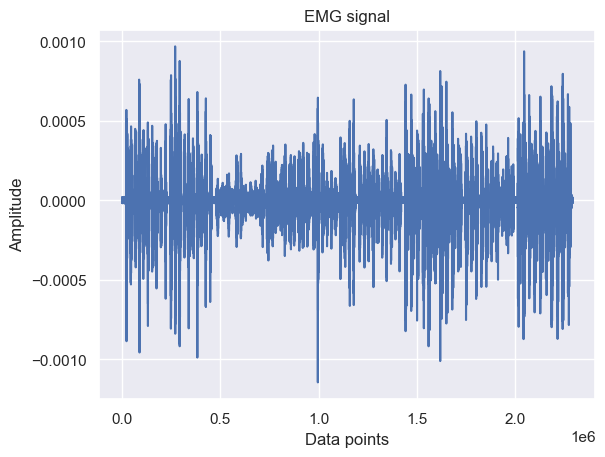

In [7]:
# Plot first channel to get a sense of the data
fs = 2000

emg_data = emg_data[:,:]
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 5])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

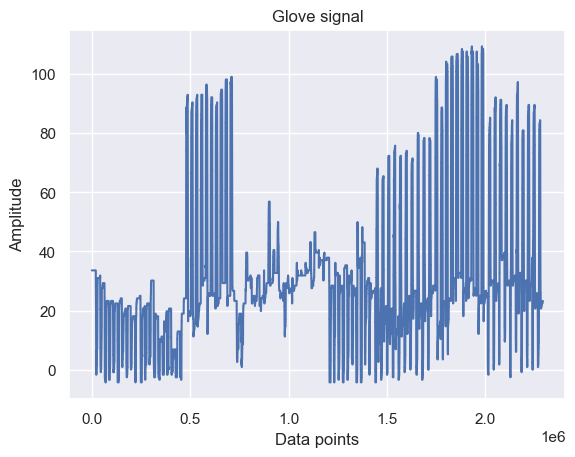

In [8]:
# Plot first channel of glove data
glove = glove[:,:]
plt.close("all")
fig, ax = plt.subplots()
ax.plot(glove[:, 5])   
ax.set_title("Glove signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

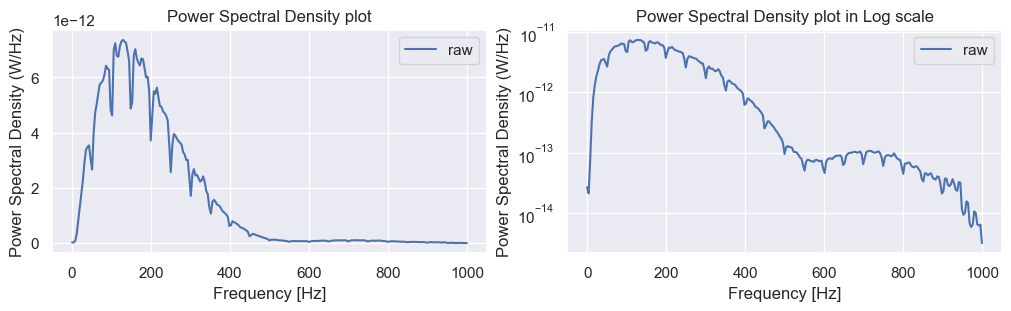

In [9]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 5], fs=2000, nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

In [10]:
def filter_signal(emg):
    bandpass_cutoff_frequencies_Hz = (5, 500) 
    sos = butter(N=4, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
    emg_filtered = sosfiltfilt(sos, emg.T).T

    powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics
    for noise_frequency in powergrid_noise_frequencies_Hz:
        sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

    return emg_filtered

In [11]:
def plot_frequency_spectrum(emg):
    n_samples = emg.shape[0]
    freq = fftfreq(n_samples, 1/fs)[:n_samples//2]
    
    fft_vals = fft(emg[:, 0])
    magnitude = 2.0/n_samples * np.abs(fft_vals[0:n_samples//2])
    
    zoom = len(freq)//2
    
    plt.figure(figsize=(15, 4))
    plt.plot(freq[:zoom], magnitude[:zoom])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    xticks = range(0, int(max(freq[:zoom])) + 50, 50)
    plt.xticks(xticks, rotation=45)
    for freq_line in range(0, int(max(freq[:zoom])), 50):
        if freq_line <= fs/2:  # Only plot up to Nyquist
            plt.axvline(x=freq_line, color='k', linestyle='--', alpha=0.5)
    plt.show()

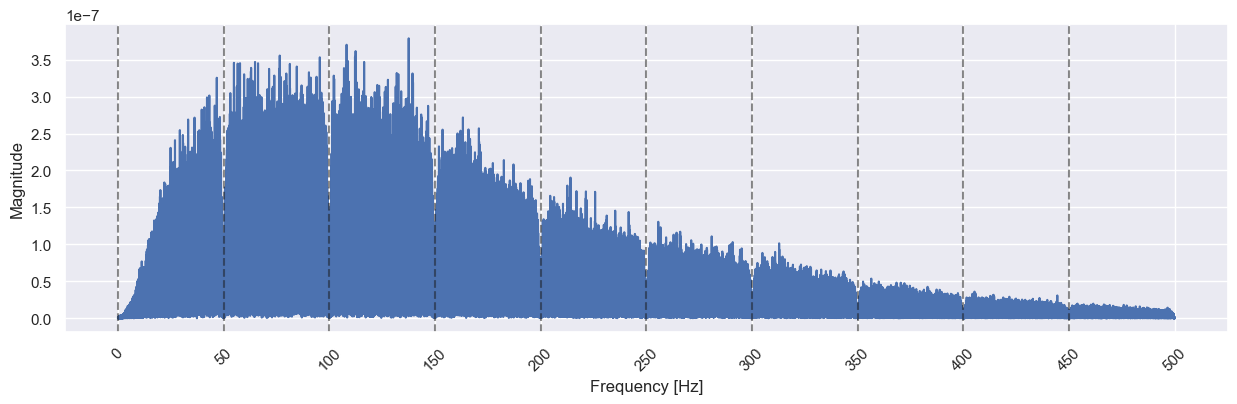

In [12]:
plot_frequency_spectrum(emg_data)

In [13]:
emg_data = filter_signal(emg_data)
emg_data.shape

(2292526, 16)

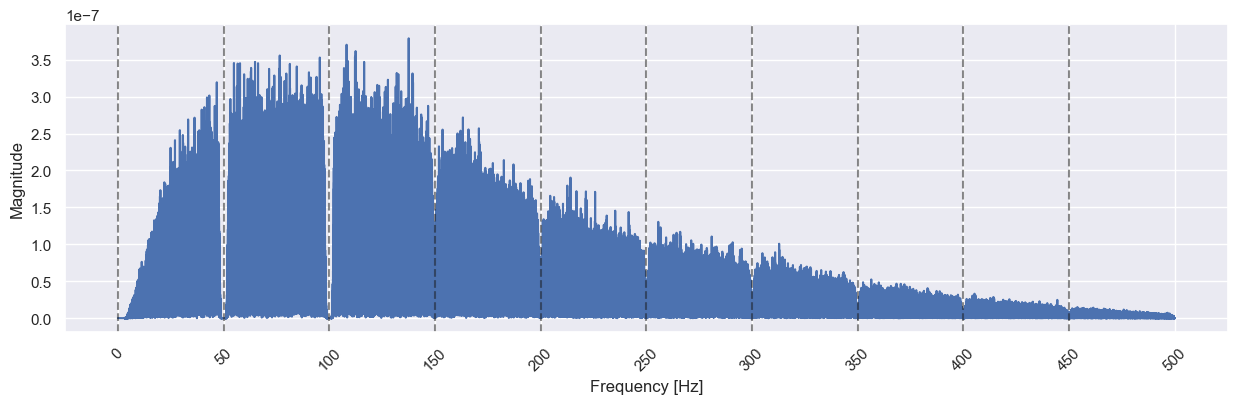

In [14]:
plot_frequency_spectrum(emg_data)

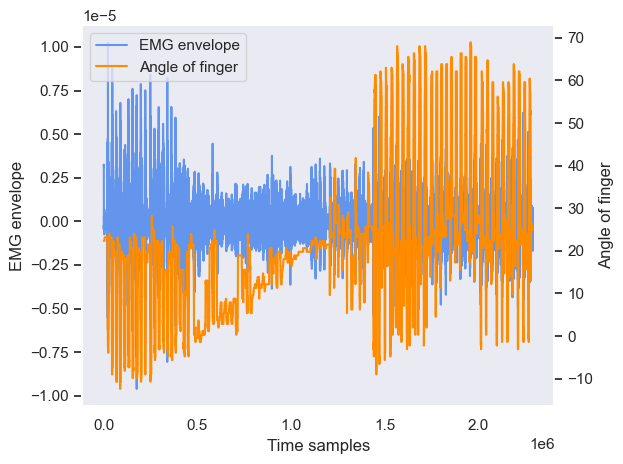

In [15]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[:, 0], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

### Split the dataset into training, validation and test sets

In [ ]:
# Chronologically cut the whole dataset before creating overlapping windows
EMG_train, EMG_testing, Labels_train, Labels_testing = train_test_split(emg_data, glove_data_index, test_size=0.3, shuffle=False)
EMG_val, EMG_test, Labels_val, Labels_test = train_test_split(EMG_testing, Labels_testing, test_size=0.5, shuffle=False)

print(f"EMG train data shape: {EMG_train.shape},    Train label shape: {Labels_train.shape}")
print(f"EMG test data shape: {EMG_test.shape},      Test label shape: {Labels_test.shape}")
print(f"EMG val data shape: {EMG_val.shape},      Val label shape: {Labels_val.shape}")



EMG train data shape: (1604768, 16),    Train label shape: (1604768, 5)
EMG test data shape: (343879, 16),      Test label shape: (343879, 5)
EMG val data shape: (343879, 16),      Val label shape: (343879, 5)


### Perform sliding windows

In [18]:
#We show the 

n_channels = emg_data.shape[1]

joints_of_interest = np.array([2, 5, 7, 10, 13])
# channels_of_interest = np.array([1, 2, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16]) - 1

n_joints = len(joints_of_interest)

emg_train = emg_train.copy()
emg_val = emg_val.copy()
emg_test = emg_test.copy()

#Time vector for plotting
time_steps_train = np.arange(0,emg_data[:train_end].shape[0]/fs, 1/fs)
time_steps_val = np.arange(0,emg_data[train_end:val_end].shape[0]/fs, 1/fs) 
time_steps_test = np.arange(0,emg_data[val_end:].shape[0]/fs, 1/fs) 

print("Time steps train shape: ", time_steps_train.shape)
print("Time steps val shape: ", time_steps_val.shape)
print("Time steps test shape: ", time_steps_test.shape)

#We rectify emg data for the three of them
emg_train = np.abs(emg_train) 
emg_val = np.abs(emg_val) 
emg_test = np.abs(emg_test) 

#We define the moving average window. A longer one is used for the glove angles than emg
mov_mean_length_glove = int(130*1e-3*fs) #130 ms for the glove angles
mov_mean_weights_glove = np.ones(mov_mean_length_glove) / mov_mean_length_glove

#We define another one for the emg. It should be shorter to keep the signal quality over window
mov_mean_length_emg = int(20*1e-3*fs) #20 ms for the emg data
mov_mean_weights_emg = np.ones(mov_mean_length_emg) / mov_mean_length_emg


#We smooth all the data with a moving average
ang_train = convolve1d(ang_train, mov_mean_weights_glove, axis=0)
emg_train = convolve1d(emg_train, mov_mean_weights_emg, axis=0)
    
ang_val = convolve1d(ang_val, mov_mean_weights_glove, axis=0)
emg_val = convolve1d(emg_val, mov_mean_weights_emg, axis=0) 

ang_test = convolve1d(ang_test, mov_mean_weights_glove, axis=0) 
emg_test = convolve1d(emg_test, mov_mean_weights_emg, axis=0) 

#We store them in variables
EMG_envelopes_train = emg_train[:, :]
glove_envelopes_train = ang_train

EMG_envelopes_val = emg_val[:, :]
glove_envelopes_val = ang_val

EMG_envelopes_test = emg_test[:, :]
glove_envelopes_test = ang_test

print("Done")

Time steps train shape:  (1604768,)
Time steps val shape:  (343879,)
Time steps test shape:  (343879,)
Done


In [19]:
print(EMG_envelopes_train.shape)

(1604768, 16)


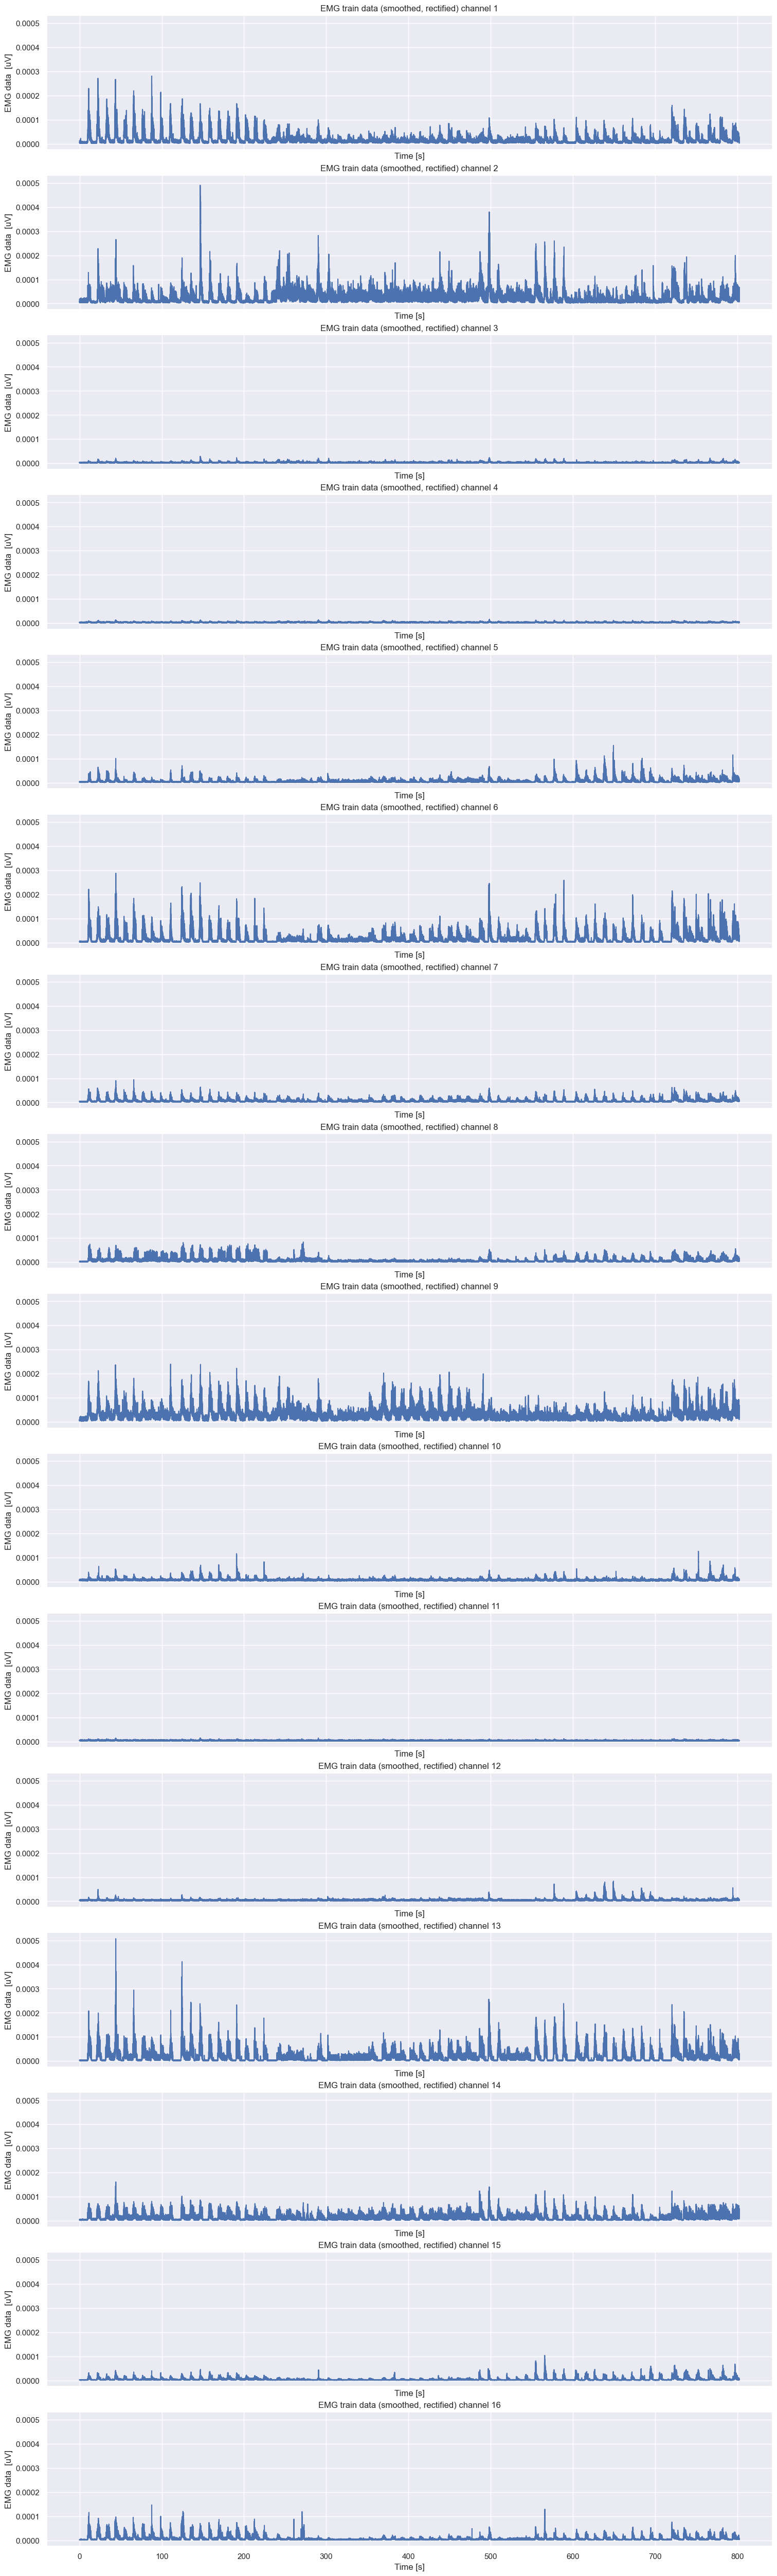

In [20]:
#We plot the smoothed, rectified data for each channel (TRAIN data)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 50), sharex=True, sharey=True)
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps_train, EMG_envelopes_train[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"EMG data  [uV]")
    ax[channel_idx].set_title(f"EMG train data (smoothed, rectified) channel {channel_idx+1}")

plt.show()

In [21]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 150e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

print("Done")

Done


In [22]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

print("Done")

Done


In [23]:
#We perform sliding window on the three sets to extract the features later
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_envelopes_train, glove_envelopes_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_val_windows, Labels_val_windows = extract_time_windows_regression(EMG_envelopes_val, glove_envelopes_val, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_envelopes_test, glove_envelopes_test, fs, emg_window_length_sec, incremental_window_length_sec)


print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG val data shape: {EMG_val_windows.shape}, Val label shape: {Labels_val_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

EMG train data shape: (16045, 300, 16), Train label shape: (16045, 300, 5)
EMG val data shape: (3436, 300, 16), Val label shape: (3436, 300, 5)
EMG test data shape: (3436, 300, 16), Test label shape: (3436, 300, 5)


### Extract a set of features

In [24]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)

    Labels_mean = np.mean(Labels_windows,axis=1)

    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((
        EMG_mean, 
        EMG_std, 
        EMG_max_amplitude,
    ), axis=1)
    return EMG_extracted_features, Labels_mean

In [25]:
#We extract the features

EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_val_windows,Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

#We print their dimensions
print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (16045, 48), Finger labels feature shape:(16045, 5)
EMG val extracted features shape: (3436, 48), Finger labels feature shape:(3436, 5)
EMG test extracted features shape: (3436, 48), Finger labels feature shape:(3436, 5)


### Normalizing set of features 

In [26]:
#We normalize the features, and keep the normalization parameters. They will be used for validation and testing
#We use z-score normalization, because the EMG data may contain outliers

#Normalization matrices
norm_mean = np.mean(EMG_train_extracted_features, axis=0)
norm_std = np.std(EMG_train_extracted_features, axis=0)

#We print its dimensions
print(f"Mean matrix shape: {norm_mean.shape}")
print(norm_mean)

print(f"Std matrix shape: {norm_std.shape}")
print(norm_std)

Mean matrix shape: (48,)
[1.72601479e-05 2.45684439e-05 3.51594277e-06 3.18273341e-06
 7.08634611e-06 1.73600050e-05 7.02472165e-06 7.44471287e-06
 3.06513110e-05 8.08031216e-06 4.23289940e-06 5.00149165e-06
 1.82163617e-05 1.44562827e-05 5.20917365e-06 7.30402423e-06
 5.43732611e-06 9.20837600e-06 8.85990192e-07 7.28872303e-07
 2.37451056e-06 6.07404186e-06 2.09206674e-06 3.27320611e-06
 9.32715859e-06 1.88407604e-06 7.70004337e-07 1.30580107e-06
 7.29340388e-06 5.83594665e-06 1.47994497e-06 2.39870873e-06
 3.01073124e-05 4.62226119e-05 5.60142483e-06 4.87027237e-06
 1.28203706e-05 3.18335979e-05 1.20308107e-05 1.57237774e-05
 5.24869881e-05 1.25720313e-05 6.02645441e-06 8.13289577e-06
 3.56098634e-05 2.83269632e-05 8.78734462e-06 1.31377876e-05]
Std matrix shape: (48,)
[1.68084953e-05 2.02487982e-05 1.23294498e-06 7.47118479e-07
 5.71370964e-06 1.91274308e-05 5.08175657e-06 5.87704957e-06
 1.98251715e-05 3.82449551e-06 5.52610712e-07 2.41263468e-06
 1.99912363e-05 9.87177114e-06 4.50

In [27]:
#Normalization function

def normalize(x, mean_matrix, std_matrix):
    return (x - mean_matrix)/std_matrix

In [28]:
#Fit and predict using the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

print("Base")
print(np.mean(EMG_test_extracted_features, axis=0))

#We put these into the relevant variables for fitting/evaluation
X_train = normalize(EMG_train_extracted_features, norm_mean, norm_std)
X_val = normalize(EMG_val_extracted_features, norm_mean, norm_std)
X_test = normalize(EMG_test_extracted_features, norm_mean, norm_std)

Y_train = Labels_train_mean
Y_val = Labels_val_mean
Y_test = Labels_test_mean

print("Train set shape")
print(X_train.shape)
print(Y_train.shape)

print("Validation set shape")
print(X_val.shape)
print(Y_val.shape)

print("Test set shape")
print(X_test.shape)
print(Y_test.shape)

#To check if normalization has been done properly
#We observe that normalization works well accross the sets
print(np.mean(X_test, axis=0))
print(np.std(X_test, axis=0))

Base
[2.34579625e-05 3.49651690e-05 3.87731713e-06 3.23214829e-06
 7.78843764e-06 2.38899412e-05 8.07319479e-06 7.08145933e-06
 4.18498767e-05 9.20526969e-06 4.02683472e-06 4.76305878e-06
 2.14828830e-05 1.64764284e-05 5.36915763e-06 9.26058153e-06
 7.16987537e-06 1.26736967e-05 1.01919159e-06 7.34439922e-07
 2.61871081e-06 8.79783073e-06 2.56801703e-06 2.61712302e-06
 1.23479042e-05 2.53862686e-06 7.42253524e-07 1.21088011e-06
 7.96373699e-06 6.41811972e-06 1.52820634e-06 2.70709775e-06
 4.01987584e-05 6.45686246e-05 6.29185208e-06 4.94791344e-06
 1.40697626e-05 4.46832392e-05 1.42033721e-05 1.36148030e-05
 7.05055650e-05 1.53565514e-05 5.77366568e-06 7.65565600e-06
 4.04774566e-05 3.14698222e-05 9.04046312e-06 1.56670457e-05]
Train set shape
(16045, 48)
(16045, 5)
Validation set shape
(3436, 48)
(3436, 5)
Test set shape
(3436, 48)
(3436, 5)
[ 0.36873108  0.51344899  0.29309853  0.06614062  0.12287841  0.34139118
  0.20632101 -0.06180883  0.56486602  0.29414534 -0.37289303 -0.09882676

### Visualize correlation of features

In [29]:
def compute_corr_matrix_normalized(X): 
    #We standardize the features before to avoid any scaling effect
    # X_corr_mean = np.mean(X_corr, axis=0) 
    # X_corr_std = np.std(X_corr, axis=0)
    # X_corr_normalized = (X_corr - X_corr_mean) / X_corr_std
    
    # Calculate the cross-correlation matrix (Pearson correlation)
    corr_matrix = np.corrcoef(X, rowvar=False)

    return corr_matrix

print("Done")

Done


In [34]:
n_features_channels = 3
all_channels = emg_data[1]
print("All channels: ", all_channels)

All channels:  [ 5.81018366e-06  4.07065491e-07 -3.04082565e-06 -1.88853496e-06
  2.68297329e-06 -2.54745148e-06  3.08373201e-06  1.53388775e-06
  1.38820936e-06  1.19454726e-06  4.11288913e-06  2.63589715e-06
 -2.09092924e-06  5.00623395e-06 -1.09999267e-06  5.96587590e-06]


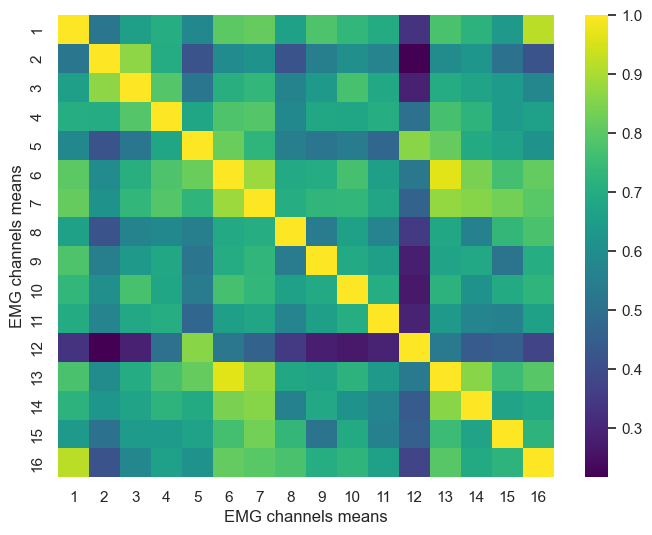

In [47]:
#Visualize the full correlation matrix
X_corr = X_train[:, 0:n_channels] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
ax.set_ylabel("EMG channels means")
ax.set_xlabel("EMG channels means")

#plt.title("Confusion Matrix")
save_figures_path = "figures/"
plt.savefig(save_figures_path + "correlation_matrix_means.png", dpi=300, bbox_inches="tight")
plt.show()

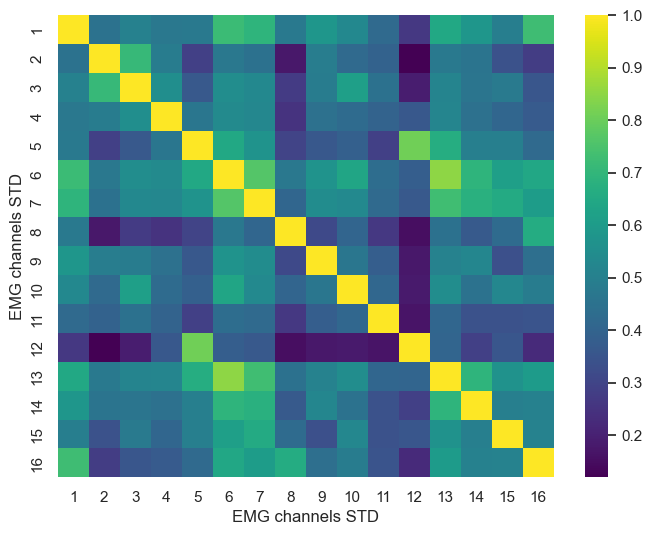

In [48]:
#Visualize the full correlation matrix
X_corr = X_train[:, n_channels*1:n_channels*2] #The STDS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
ax.set_ylabel("EMG channels STD")
ax.set_xlabel("EMG channels STD")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()

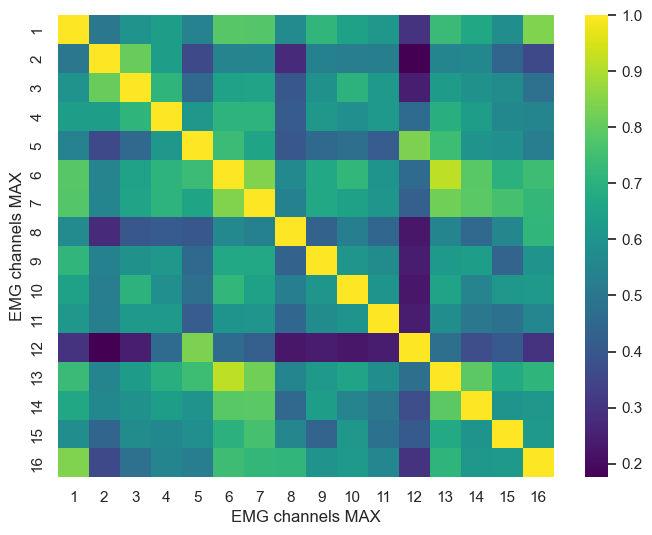

In [49]:
#Visualize the full correlation matrix
X_corr = X_train[:, n_channels*2:n_channels*3] #The MAX values are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
ax.set_ylabel("EMG channels MAX")
ax.set_xlabel("EMG channels MAX")



#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()


In [50]:
print(n_channels)

16


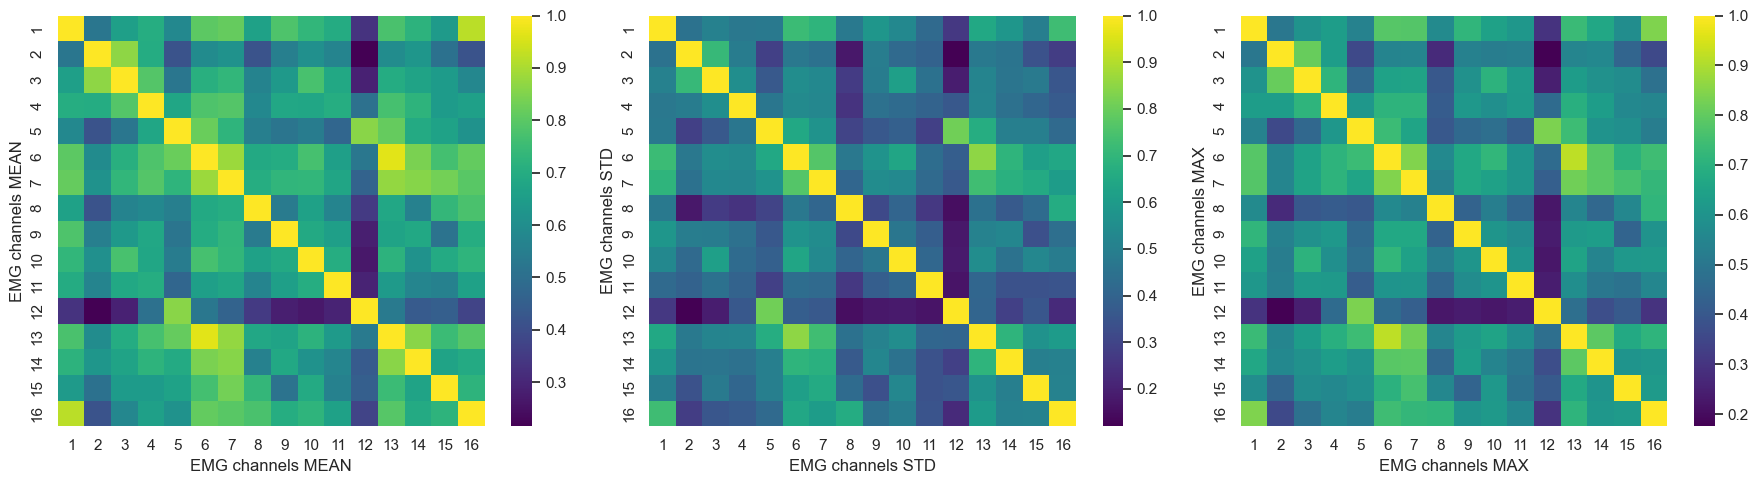

In [51]:
n_rows, n_columns = 1, 3

fig, axes = plt.subplots(n_rows, n_columns, figsize=(18, 5))

axes = axes.flatten()

all_channels = np.arange(1, n_channels+1)


X_corr = X_train[:, 0:n_channels] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[0], xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
axes[0].set_ylabel("EMG channels MEAN")
axes[0].set_xlabel("EMG channels MEAN")


X_corr = X_train[:, n_channels:n_channels*2] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[1], xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
axes[1].set_ylabel("EMG channels STD")
axes[1].set_xlabel("EMG channels STD")


X_corr = X_train[:, n_channels*2:n_channels*3] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[2], xticklabels=all_channels, yticklabels=all_channels, cmap="viridis")
axes[2].set_ylabel("EMG channels MAX")
axes[2].set_xlabel("EMG channels MAX")

X_corr = X_train[:, n_channels*3:n_channels*4] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


# Save and visualize
plt.tight_layout()
plt.savefig(save_figures_path + "correlation_subplot_grid2.png", dpi=300, bbox_inches="tight")
plt.show()

### Perform Random Forest regression 

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from scipy.stats import randint


# Base model (RF) wrapped for multi-output 
base = RandomForestRegressor(random_state=42, n_jobs=-1)
model = MultiOutputRegressor(base)

# Scoring: use negative MAE (higher is better in sklearn)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_dist = {
    "estimator__n_estimators": randint(100, 401),          # 100..400
    "estimator__max_depth": [None, 5, 10],
    "estimator__min_samples_split": randint(2, 21),        # 2..20
    "estimator__min_samples_leaf": randint(1, 6),          # 1..5
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    refit=True
)

total_fits = search.n_iter * search.cv

with tqdm_joblib(tqdm(total=total_fits, desc="RandomizedSearchCV fits")):
    search.fit(X_train, Y_train)

print("Best params:", search.best_params_)
print("Best CV score (neg MAE):", search.best_score_)
print("Best CV MAE:", -search.best_score_)  # convert to positive MAE

RandomizedSearchCV fits:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
results = pd.DataFrame(search.cv_results_)

cols = [
    "mean_test_score", "std_test_score",
    "param_estimator__n_estimators",
    "param_estimator__max_depth",   
    "param_estimator__min_samples_split",
    "param_estimator__min_samples_leaf",
]
summary = results[cols].sort_values("mean_test_score", ascending=False).head(10)

# Convert neg MAE to MAE for readability
summary = summary.rename(columns={
    "mean_test_score": "mean_CV_negMAE",
    "std_test_score": "std_CV_negMAE",
    "mean_train_score": "mean_train_negMAE"
})
summary["mean_CV_MAE"] = -summary["mean_CV_negMAE"]
summary["std_CV_MAE"] = summary["std_CV_negMAE"]

print(summary[[
    "mean_CV_MAE", "std_CV_MAE",
    "param_estimator__n_estimators",
    "param_estimator__max_depth",
    "param_estimator__min_samples_split",
    "param_estimator__min_samples_leaf",
]])

NameError: name 'search' is not defined

In [38]:
# # Define the base model
# #Parameters found through grid search
# base_model = RandomForestRegressor(search.best_params_)

# # Wrap the model in MultiOutputRegressor
# multi_model = MultiOutputRegressor(base_model)
# multi_model.fit(X_train, Y_train)
# Y_pred = multi_model.predict(X_test)

# print("Done")


# Extract RF params (remove "estimator__" prefix)
best_rf_params = {
    k.replace("estimator__", ""): v
    for k, v in search.best_params_.items()
}

print("RF params used:", best_rf_params)

# Build and fit final model on full training set
base_model = RandomForestRegressor(random_state=42, n_jobs=-1, **best_rf_params)
multi_model = MultiOutputRegressor(base_model)

multi_model.fit(X_train, Y_train)

# Predict on test set
Y_pred = multi_model.predict(X_test)

print("Done")

RF params used: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 393}
Done


### Evaluate the performance

In [54]:
print("Y test: ", Y_test)
print("Y pred: ", Y_pred)

Y test:  [[24.01417351 27.55697823 15.02089119 16.94121552 16.09381104]
 [24.01417351 27.55697823 15.02089119 16.94121552 16.09381104]
 [24.01417351 27.55697823 15.02089119 16.94121552 16.09381104]
 ...
 [24.86123466 23.25119972 13.94797039 -4.23530388 -2.1458416 ]
 [24.86123466 23.25119972 13.94797039 -4.23530388 -2.1458416 ]
 [24.86123466 23.25119972 13.94797039 -4.23530388 -2.1458416 ]]


NameError: name 'Y_pred' is not defined

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')

print(mse.shape)
print("Root mean sqaure error:", rmse)
print("Mean absolute error:", mae)
print("R2 score:", r2)

(5,)
Root mean sqaure error: [26.29804103 34.9560035  45.71571336 23.51837717 24.99980036]
Mean absolute error: [17.6648852  22.18746815 28.80840571 14.85084826 17.46937403]
R2 score: [-1.11470599 -0.38951177 -0.37267313  0.32571731  0.33121548]


### Is the regression performance stable across the different finger angles?

ValueError: x and y must have same first dimension, but have shapes (10000,) and (3436,)

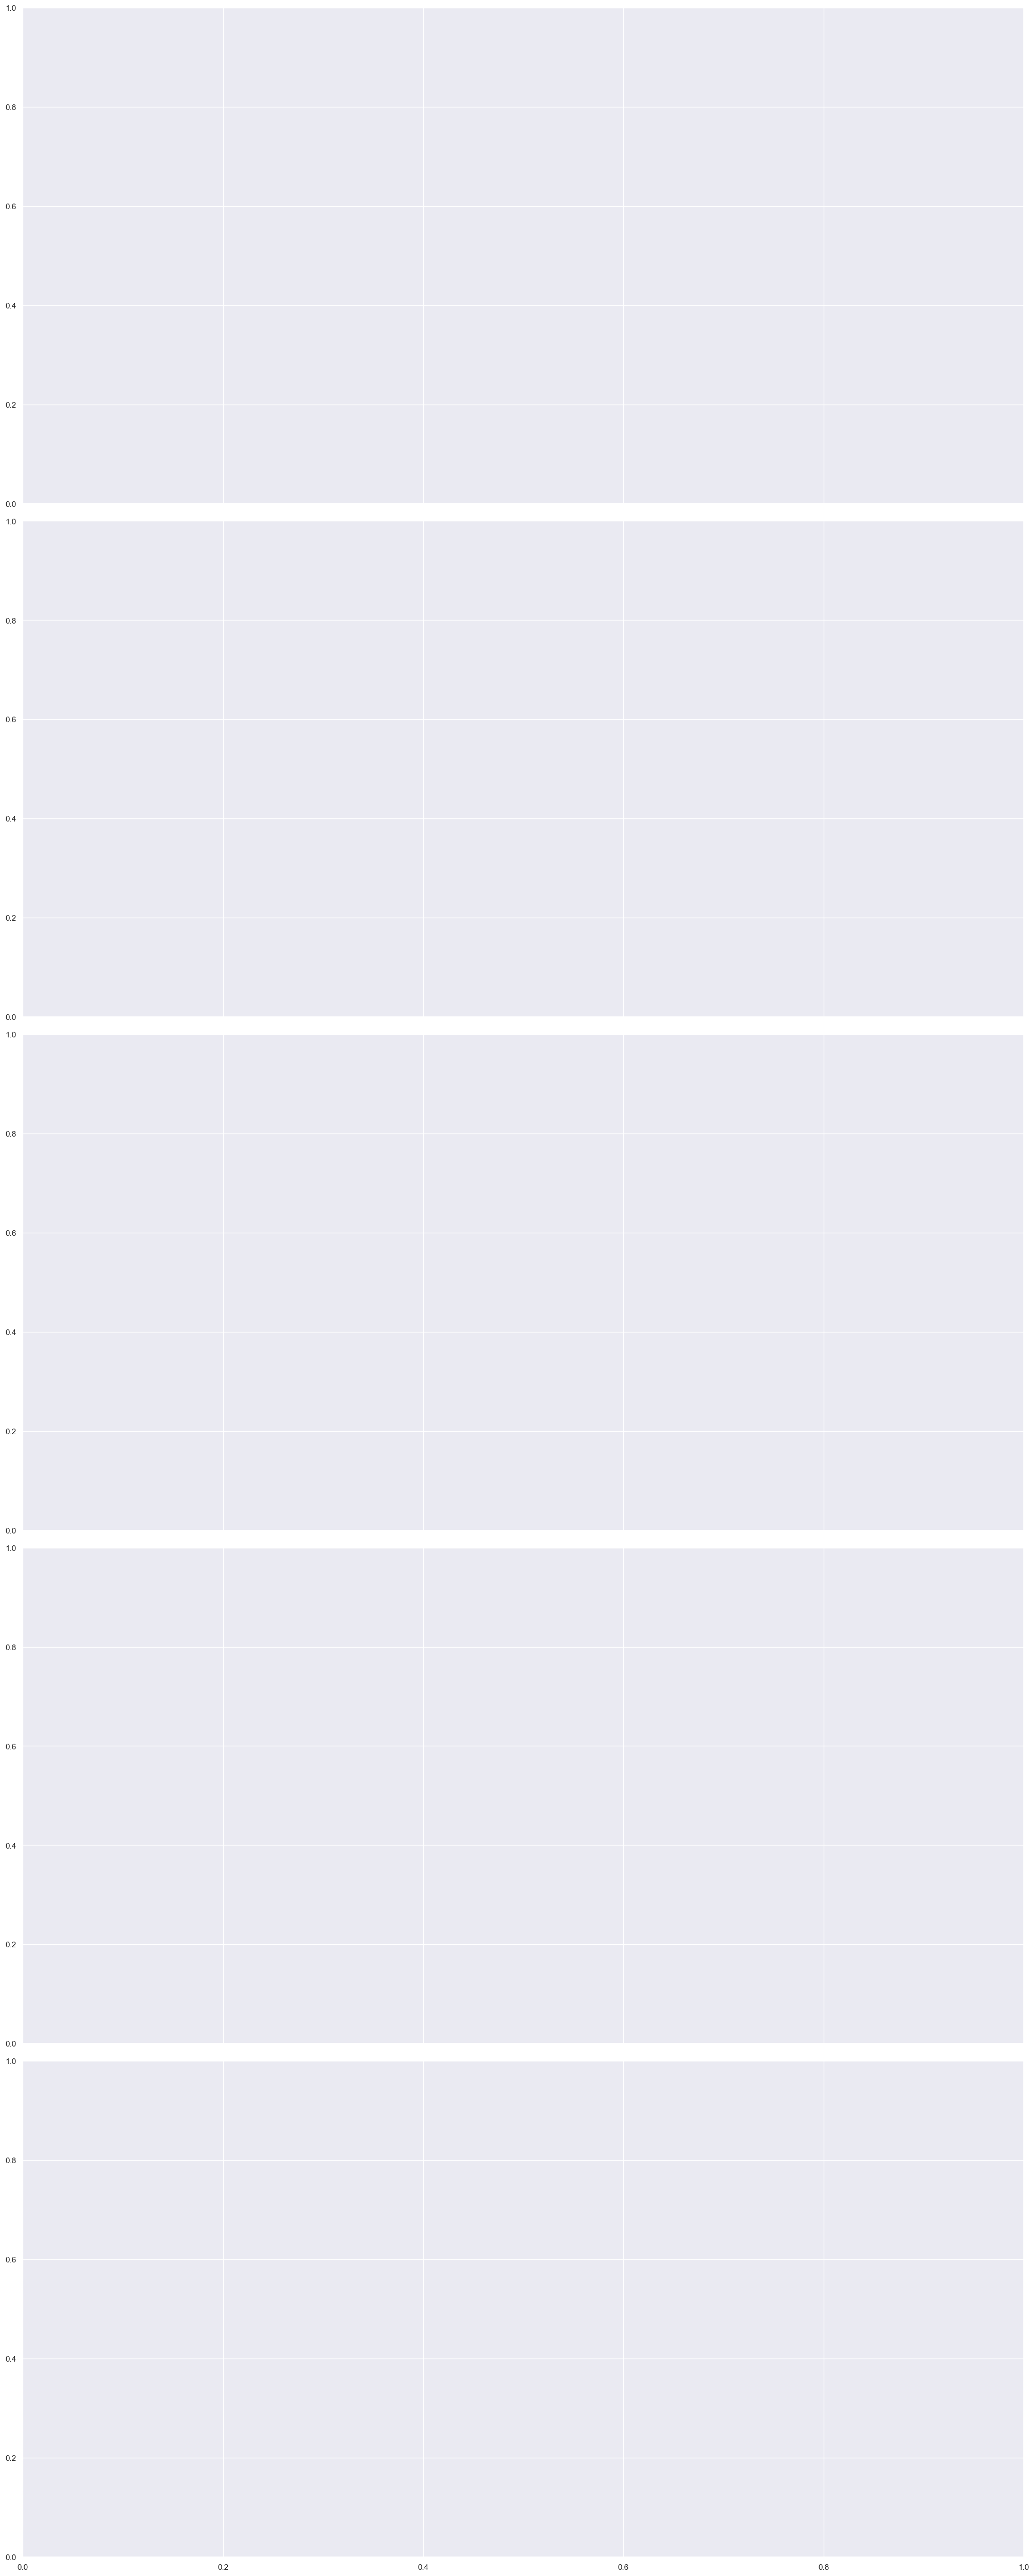

In [ ]:
nb_windows_t_print = 1000
save_figures_path = "figures"

fig, ax = plt.subplots(n_joints, 1, constrained_layout=True, figsize=(20, 50), sharex=True, sharey=True)
for i in range(n_joints):
    x = np.arange(nb_windows_t_print)
    ax[i].plot(x, Y_test[:nb_windows_t_print, i], color='b', label='True joint angle')
    ax[i].plot(x, Y_pred[:nb_windows_t_print, i], color='r', alpha=0.7, label='Prediction')
    ax[i].set_xlabel("Windows (not time)")
    ax[i].set_ylabel(f"Joint angle {joints_of_interest[i]+1}")
    ax[i].set_title(f"Joint angle {joints_of_interest[i]+1}")

    ax[i].text(
        0.95, 0.05, f'MSE: {mse[i]:.4f}\nRMSE: {rmse[i]:4f}\nMAE: {mae[i]:4f}',
        transform=ax[i].transAxes,
        fontsize=16,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax[i].legend()

plt.savefig(save_figures_path + "angle_pred2 50 estimators ma 128 ms sw 50 ms.png", dpi=300, bbox_inches="tight")
plt.show()
print("Done")

In [41]:
def exponential_moving_average(data, alpha=0.3):
    """
    Compute the Exponential Moving Average (EMA) of a 1D array.
    
    Parameters:
    - data: 1D NumPy array of data points
    - alpha: Smoothing factor (0 < alpha <= 1)
    
    Returns:
    - 1D NumPy array of EMA values
    """
    ema = np.zeros_like(data)  # Initialize an array to store EMA values
    ema[0] = data[0]           # First EMA value is the first data point
    
    # Iteratively compute EMA
    for t in range(1, len(data)):
        ema[t] = alpha * data[t] + (1 - alpha) * ema[t-1]
    
    return ema

In [42]:
def rect_filter_past(data, filter_size):
    output = np.zeros_like(data)
    for i in range(filter_size-1, len(data)):
        sum_ = 0
        for j in range(i-filter_size+1, i+1):
            sum_ += data[j]/filter_size
        output[i, :] = sum_
    return output
            

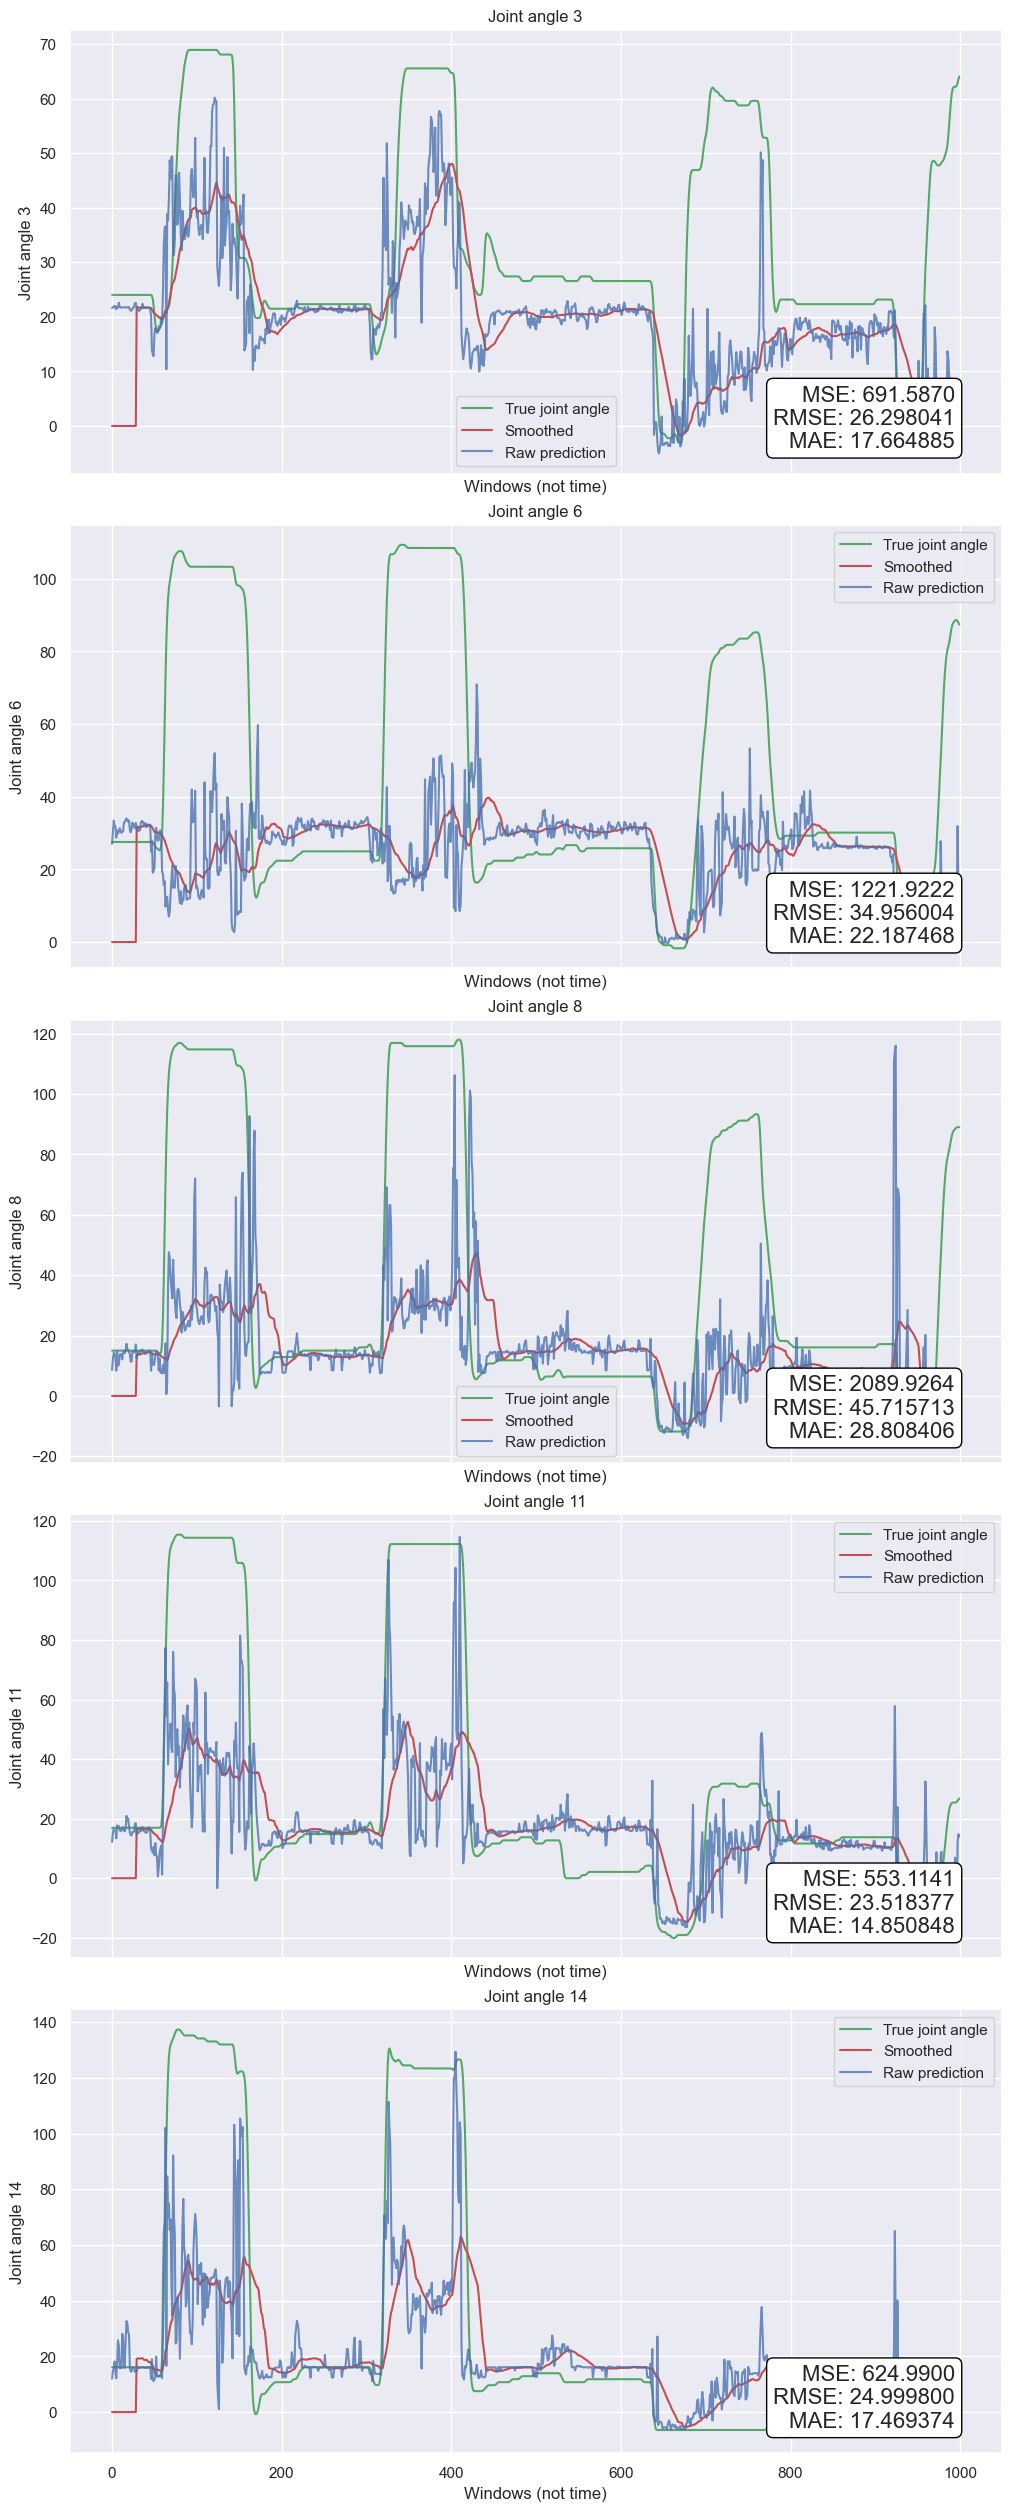

Done


In [43]:
#Useful to answer to the question: Is there a joint angle for which the predictions are less good than usual? 
nb_windows_t_print = 1000
save_figures_path = "figures/"

filter_size = 30
mov_mean_output_weigths = np.ones(filter_size) / filter_size

#Y_pred_smoothed = convolve1d(Y_pred, mov_mean_output_weigths, axis=0)
Y_pred_smoothed = rect_filter_past(Y_pred, filter_size)

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')


fig, ax = plt.subplots(n_joints, 1, constrained_layout=True, figsize=(10, 25), sharex=True, sharey=False)
for i in range(n_joints):
    x = np.arange(nb_windows_t_print)
    ax[i].plot(x, Y_test[:nb_windows_t_print, i], color='g', alpha=1, label='True joint angle')
    ax[i].plot(x, Y_pred_smoothed[:nb_windows_t_print, i], color='r', alpha=1, label='Smoothed')
    ax[i].plot(x, Y_pred[:nb_windows_t_print, i], color='b', alpha=0.8, label='Raw prediction')
    ax[i].set_xlabel("Windows (not time)")
    ax[i].set_ylabel(f"Joint angle {joints_of_interest[i]+1}")
    ax[i].set_title(f"Joint angle {joints_of_interest[i]+1}")

    ax[i].text(
        0.95, 0.05, f'MSE: {mse[i]:.4f}\nRMSE: {rmse[i]:4f}\nMAE: {mae[i]:4f}',
        transform=ax[i].transAxes,
        fontsize=16,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax[i].legend()

plt.savefig(save_figures_path + "angle_pred3 50 estimators ma 128 ms sw 50 ms.png", dpi=300, bbox_inches="tight")
plt.show()
print("Done")